# Introduction
The purpose of this notebook is to help facilitate geolocation matching between physical and virtual gauges. Physical gauges are streamflow gauges located in a river, and virtual gauges are locations in global rivers where the Google flood forecast model makes predcitions.

The problem of matching physical gauge locations (given in lat/loncoordinates) with prediction points (virtual gauges) can be difficult and sometimes requires local hydrological knowledge. We recommend doing this by hand whenever possible. This notebook provides tools to assist that process.

This notebook provides the following two things:

*  Metadata for all prediction points (virtual gauges) in a set of countries. This is useful if you want to run your own location mathing algorithms, or to do location matching with external software (e.g., GIS).

*  Algorithmic and visual tools to assist location matching.

#Step 0: Notebook Setup

In [ ]:
# Set this to False if you are running this Colab outside of Google.
GOOGLE_INTERNAL = True

## Imports

In [ ]:
# Overwrite standard Python function to read from CNS.
if GOOGLE_INTERNAL:
  open_fn = gfile.Open
  glob_fn = gfile.Glob
else:
  open_fn = open
  import glob
  glob_fn = gl.glob

In [ ]:
if not GOOGLE_INTERNAL:
  !pip install zarr xarray

In [ ]:
import branca.element
import folium
import folium.plugins
import geopandas as gpd
from geopy.distance import geodesic
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import os
import pandas as pd
from shapely.geometry import box, Polygon, Point
from tqdm import notebook as tqdm
import xarray as xr

## Local Paths
Replace these with your own local paths.

In [ ]:
# Top level directory where the HyBAS shapefiles are located.
# Subdirectories in this path are two-letter abbreviations of the HyBAS continents.
# Each subdirectory contains geojson files containing HyBAS polygons at different spatial resolutions (1-12).
# HyBAS shapefiles can be downloaded from here: https://www.hydrosheds.org/products/hydrobasins
HYBAS_SHAPEFILE_PATH = '/cns/jn-d/home/floods/hydro_model/datasets/external/HydroBASINS/geojson'

In [ ]:
# Directory where you want to store the data and metadata extracted by this notebook.
OUTPUT_SAVE_PATH = '/cns/iz-d/home/floods/hydro_model/work/gsnearing/country_gauge_extraction'

if not GOOGLE_INTERNAL:
  if not os.path.exists(OUTPUT_SAVE_PATH):
    os.makedirs(OUTPUT_SAVE_PATH)
else:
  if not gfile.Exists(OUTPUT_SAVE_PATH):
    gfile.MakeDirs(OUTPUT_SAVE_PATH)

##Miscelaneous Setup

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Step 1: Extract Virtual Gauges
Extract all of the prediction points (virtual gauges) that are within the administrative borders of a list of countries.

**Important Note** Coastal basins are watersheds that drain directly to an ocean indepnedent of a river. As an example, where the Amazon River drains to the Atlantic Ocean is *not* a coastal basin because this is the outlet point of a river. For coastal basins, the outlet point is not well-defined. In such cases, the HydroSheds dataset generated Prof. Lehner includes many possible outlet points. For simplicity, we arbitrarily select one of them. Please use the points representing coastal basins with caution.

## Countries to Extract
The variable `COUNTRIES_TO_EXTRACT` contains a list of countries where we want to extract prediction points (virtual gauges).

Country names must match standard GeoPandas country names. A tool is provided below to list all country names.

### List of Available Countries

In [ ]:
GPD_GEOMETRY_COLUMN_HEADER = 'geometry'
if not GOOGLE_INTERNAL:
  geopandas_country_shapefile_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
  GPD_COUNRY_NAME_COLUMN_HEADER = 'SOVEREIGNT'
  GPD_CONTINENT_COLUMN_HEADER = 'CONTINENT'
  world_gdf = gpd.read_file(geopandas_country_shapefile_url)
else:
  GPD_COUNRY_NAME_COLUMN_HEADER = 'name'
  GPD_CONTINENT_COLUMN_HEADER = 'continent'
  world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geopandas_countries = list(set(world_gdf[GPD_COUNRY_NAME_COLUMN_HEADER]))
geopandas_countries.sort()
print(f'There are {len(geopandas_countries)} countries in the GeoPandas shapefile: ')
print(geopandas_countries)

There are 177 countries in the GeoPandas shapefile: 
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herz.', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Rep.', 'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Dem. Rep. Congo', 'Denmark', 'Djibouti', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador', 'Eq. Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Is.', 'Fiji', 'Finland', 'Fr. S. Antarctic Lands', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', '

### Define Countries to Extract

In [ ]:
COUNTRIES_TO_EXTRACT = ['Mali']

# Check that all countries are in the shapefile.
countries_not_in_shapefile = [
    c for c in COUNTRIES_TO_EXTRACT if c not in geopandas_countries]
if countries_not_in_shapefile:
  print('Not all countries are in the GeoPandas Shapefile.')
  print(f'Missing Countries: {countries_not_in_shapefile}.')
else:
  print('All countries were found in the GeoPandas shapefile.')

All countries were found in the GeoPandas shapefile.


##Find Virtual Gauges

### Load All Virtual Gauge Locations

In [ ]:
if not GOOGLE_INTERNAL:
  grrr_base_directory = 'gs://flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'

  def open_zarr(path):
    return xr.open_zarr(
        store=path,
        chunks=None,
        storage_options=dict(token='anon')
    )

else:
  grrr_base_directory = '/bigstore/flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'

  def open_zarr(path):
    return xr.open_zarr(store=path, chunks=None)

# Get all prediction points in the GRRR dataset.
outlets_path = os.path.join(grrr_base_directory, 'hybas_outlet_locations_UNOFFICIAL.zarr/')
outlets_ds = open_zarr(outlets_path)
grrr_virtual_gauges_df = outlets_ds.to_dataframe()
del outlets_ds

# Count the total number of virtual gauges.
grrr_virtual_gauges = grrr_virtual_gauges_df.index.tolist()
print(f'There are {len(grrr_virtual_gauges)} virtual gauges in the global GRRR dataset.')

There are 1034083 virtual gauges in the global GRRR dataset.


### Filter Virtual Gaguges by Country#

In [ ]:
# Helper code.
def is_point_in_polygon(gdf, lat, lon):
  """
  Checks if a given latitude and longitude point is inside any polygon in a
  GeoDataFrame.

  Args:
    gdf (GeoDataFrame): The GeoDataFrame containing the polygons.
    lat (float): The latitude of the point.
    lon (float): The longitude of the point.

  Returns:
    tuple: A tuple containing:
      - bool: True if the point is inside any polygon, False otherwise.
      - str or None: The name of the country if inside, or None if not.
  """

  # Note: Shapely uses (lon, lat)
  point = Point(lon, lat)

  for _, row in gdf.iterrows():
    if row[GPD_GEOMETRY_COLUMN_HEADER].contains(point):
      return True, row.get(GPD_COUNRY_NAME_COLUMN_HEADER)
  return False, None


def get_minimal_bounding_box(gdf):
    """
    Calculates the minimal bounding box around a set of GeoPandas geometries.

    Args:
        gdf (GeoDataFrame): A GeoDataFrame containing geometries.

    Returns:
      tuple: A tuple containing:
        - GeoDataFrame: A GeoDataFrame representing the minimal bounding box.
        - List[float]: Lat/lon coordinates of corners of the bounding box.
    """
    if gdf.empty:
        return None

    # Get the total bounds of all geometries.
    minx, miny, maxx, maxy = gdf.total_bounds

    # Create a Shapely box from the bounds.
    bounding_box = box(minx, miny, maxx, maxy)

    # Create a GeoDataFrame from the bounding box.
    bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs=gdf.crs)

    return bounding_box_gdf, [minx, miny, maxx, maxy]


def is_in_box(row, bb_coords):
  return (
      row.latitude > bb_coords[1] and
      row.latitude < bb_coords[3] and
      row.longitude > bb_coords[0] and
      row.longitude < bb_coords[2]
  )

In [ ]:
# Subset of the global administrative boundary shapefile for extracting gauges.
countries_gdf = world_gdf[world_gdf[GPD_COUNRY_NAME_COLUMN_HEADER].isin(COUNTRIES_TO_EXTRACT)]
countries_gdf = countries_gdf.set_index(GPD_COUNRY_NAME_COLUMN_HEADER)

# Get continents for all countries in the request.
continents = list(set(countries_gdf[GPD_CONTINENT_COLUMN_HEADER]))
print(f'The requested countries exist on the following continent(s): {continents}.')

The requested countries exist on the following continent(s): ['Africa'].


In [ ]:
# Get a bounding box to filter points before running the geospatial algo.
# This reduces run time.
bounding_box, bounding_box_coordinates = get_minimal_bounding_box(countries_gdf)

# Filter the virtual gauges by bounding box & country polygons.
virtual_gauges_in_countries = []
virtual_gauges_in_bounding_box = []
for gauge, row in tqdm.tqdm(grrr_virtual_gauges_df.iterrows()):
  if is_in_box(row, bounding_box_coordinates):
    virtual_gauges_in_bounding_box.append(gauge)
    is_inside, _ = is_point_in_polygon(countries_gdf, row.latitude, row.longitude)
    if is_inside:
      virtual_gauges_in_countries.append(gauge)

virtual_gauges_in_countries_df = grrr_virtual_gauges_df.loc[virtual_gauges_in_countries]

# Report counts.
print(f'There are {len(grrr_virtual_gauges)} virtual gauges in the global GRRR dataset.')
print(f'There are {len(virtual_gauges_in_bounding_box)} virtual gauges in the bounding box.')
print(f'There are {len(virtual_gauges_in_countries)} virtual gauges in the specified countries ({COUNTRIES_TO_EXTRACT}).')

0it [00:00, ?it/s]

There are 1034083 virtual gauges in the global GRRR dataset.
There are 22196 virtual gauges in the bounding box.
There are 9549 virtual gauges in the specified countries (['Mali']).


## Drainage Areas

### HyBAS Polygons

In [ ]:
# Helper code.
def geometries_intersect(geometry1, geometry2):
  """
  Checks if two geopandas geometries intersect.

  Args:
    geometry1: The first geometry.
    geometry2: The second geometry.

  Returns:
    True if the geometries intersect, False otherwise.
  """
  return geometry1.intersects(geometry2)


def is_country_in_hybas_continent(country_gdf, hybas_gdf):
  """
  Checks if a country is in a continent.

  Args:
    country_gdf: The geopandas dataframe of the country.
    hybas_gdf: The geopandas dataframe of the continent.

  Returns:
    True if the country is in the continent, False otherwise.
  """
  for _, country_row in country_gdf.iterrows():
    for _, hybas_row in hybas_gdf.iterrows():
      if geometries_intersect(
          country_row[GPD_GEOMETRY_COLUMN_HEADER],
          hybas_row[GPD_GEOMETRY_COLUMN_HEADER]
      ):
        return True
  return False


def continent_abbrv_from_file_name(file_name):
  """
  Extracts the continent abbreviation from a file name.

  Args:
    file_name: The file name.

  Returns:
    The continent abbreviation.
  """
  return file_name.split('/')[-2]

In [ ]:
# Find the correct HyBAS continents to load.
# This only requires checking the coarsest resolution (lev01).
hybas_filename_template = os.path.join(
    HYBAS_SHAPEFILE_PATH, '**/hybas_*_lev01_v1c.geojson')

hybas_continents = []
for continent_gdf_file in tqdm.tqdm(glob_fn(hybas_filename_template)):
  with open_fn(continent_gdf_file, 'rb') as f:
    continent_gdf = gpd.read_file(f, epsg=4326)
  if is_country_in_hybas_continent(countries_gdf, continent_gdf):
    hybas_continents.append(continent_abbrv_from_file_name(continent_gdf_file))

  # Uncomment the code below if you want to visualize the HyBAS continents.
  # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
  # continent_gdf.plot(ax=ax)
  # countries_gdf.plot(ax=ax, color='red')
  # ax.set_title(continent_abbrv_from_file_name(continent_gdf_file))
  # plt.show()

print(f'Continents containing countries for extraction: {hybas_continents}.')

  0%|          | 0/9 [00:00<?, ?it/s]

Continents containing countries for extraction: ['af'].


In [ ]:
# Here we actually load the HyBAS polygons.
# This must be done at the finest resolution (lev12) to match the virtual gauges.
hybas_filename_template = os.path.join(
    HYBAS_SHAPEFILE_PATH, '{}/hybas_{}_lev12_v1c.geojson')
hybas_shapefile_paths = [
    hybas_filename_template.format(continent, continent)
    for continent in hybas_continents
]

hybas_gdf = gpd.GeoDataFrame()
for hybas_shapefile in tqdm.tqdm(hybas_shapefile_paths):
  with open_fn(hybas_shapefile, 'rb') as f:
    continent_gdf = gpd.read_file(f)
  continent_gdf.set_index('HYBAS_ID', inplace=True)
  hybas_gdf = pd.concat([hybas_gdf, continent_gdf])

# Report totals.
print(f'There are {hybas_gdf.shape[0]} HyBAS polygons in the files that were loaded.')

  0%|          | 0/1 [00:00<?, ?it/s]

There are 230028 HyBAS polygons in the files that were loaded.
These will be filtered by country borders in the next step.


### Drainage Area Polygons
These are geographic polygons representing the join of all HyBAS polygons upstream from each virtual gauge.

In [ ]:
PARENT_NODE_COLUMN_NAME = 'NEXT_DOWN'

def get_descendants(df, node_id):
  """
  Recursively collects all descendant nodes in a tree.

  Args:
    df: DataFrame indexed by node ID with an appropriately named parent column.
    node_id: ID of the starting node.

  Returns:
    A set containing the IDs of all descendant nodes.
  """
  descendants = set([node_id])
  children = df[df[PARENT_NODE_COLUMN_NAME] == node_id].index.tolist()
  for child in children:
    descendants.add(child)
    descendants.update(get_descendants(df, child))
  return descendants


def join_polygons(gdf, start_node):
  """
  Joins all polygons with their descendants in a tree.

  Args:
    gdf: GeoDataFrame containing an appropriately named parent column.
    start_node: The ID of the starting node.

  Returns:
    A GeoDataFrame containing the joined polygons.
  """
  upstream_nodes = get_descendants(gdf, start_node)
  joined_gdf = gpd.GeoDataFrame(
      index=[start_node],
      geometry=[gdf.loc[list(upstream_nodes), GPD_GEOMETRY_COLUMN_HEADER].unary_union],
      crs=gdf.crs,
      columns=[GPD_GEOMETRY_COLUMN_HEADER]
  )
  return joined_gdf

In [ ]:
drainage_polygons = []
virtual_gauge_ids = [int(g.split('_')[-1]) for g in virtual_gauges_in_countries]
for gauge in tqdm.tqdm(virtual_gauge_ids):
  drainage_polygons.append(join_polygons(hybas_gdf, gauge))

hybas_drainage_polygons_in_countries_gdf = gpd.GeoDataFrame(
    pd.concat(drainage_polygons, ignore_index=False))
hybas_drainage_polygons_in_countries_gdf.index = ['hybas_' + str(index) for index in hybas_drainage_polygons_in_countries_gdf.index]

print(f'There are {hybas_drainage_polygons_in_countries_gdf.shape[0]} HyBAS drainage polygons.')
print(f'This number should be the same as the number of virtual gauges, which is {len(virtual_gauges_in_countries)}.')

### Drainage Areas
This provides the total drainage area for each virtual gauge.

In [ ]:
# Extract the area of each polygon in square kilometers.
HYBAS_AREA_COLUMN_NAME = 'UP_AREA'
hybas_drainage_polygons_in_countries_gdf['area'] = hybas_gdf.loc[hybas_drainage_polygons_in_countries_gdf.index, HYBAS_AREA_COLUMN_NAME]
virtual_gauges_in_countries_df['area'] = hybas_drainage_polygons_in_countries_gdf['area']

# Report some sanity statistics.
print(f'The largest drainage area in the country(ies) is {hybas_drainage_polygons_in_countries_gdf["area"].max():.1f} km2.')
print(f'The smallest drainage area in the country(ies) is {hybas_drainage_polygons_in_countries_gdf["area"].min():.1f} km2.')

,latitude,longitude,area
gauge_id,,,
hybas_1120040380,16.552083,-4.918750,78587.7
hybas_1120040400,19.314583,-3.122917,70156.4
hybas_1120040850,18.510417,-2.464583,22027.9
hybas_1120040860,17.460417,-2.672917,22021.0
hybas_1120040960,20.702083,-5.006250,16957.2
...,...,...,...
hybas_1121953810,10.281250,-7.135417,175.2
hybas_1121953990,10.268750,-7.006250,165.6
hybas_1121954390,10.243750,-7.668750,4730.9


## Plot Virtual Gauges

<ipython-input-215-528684488de4>:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


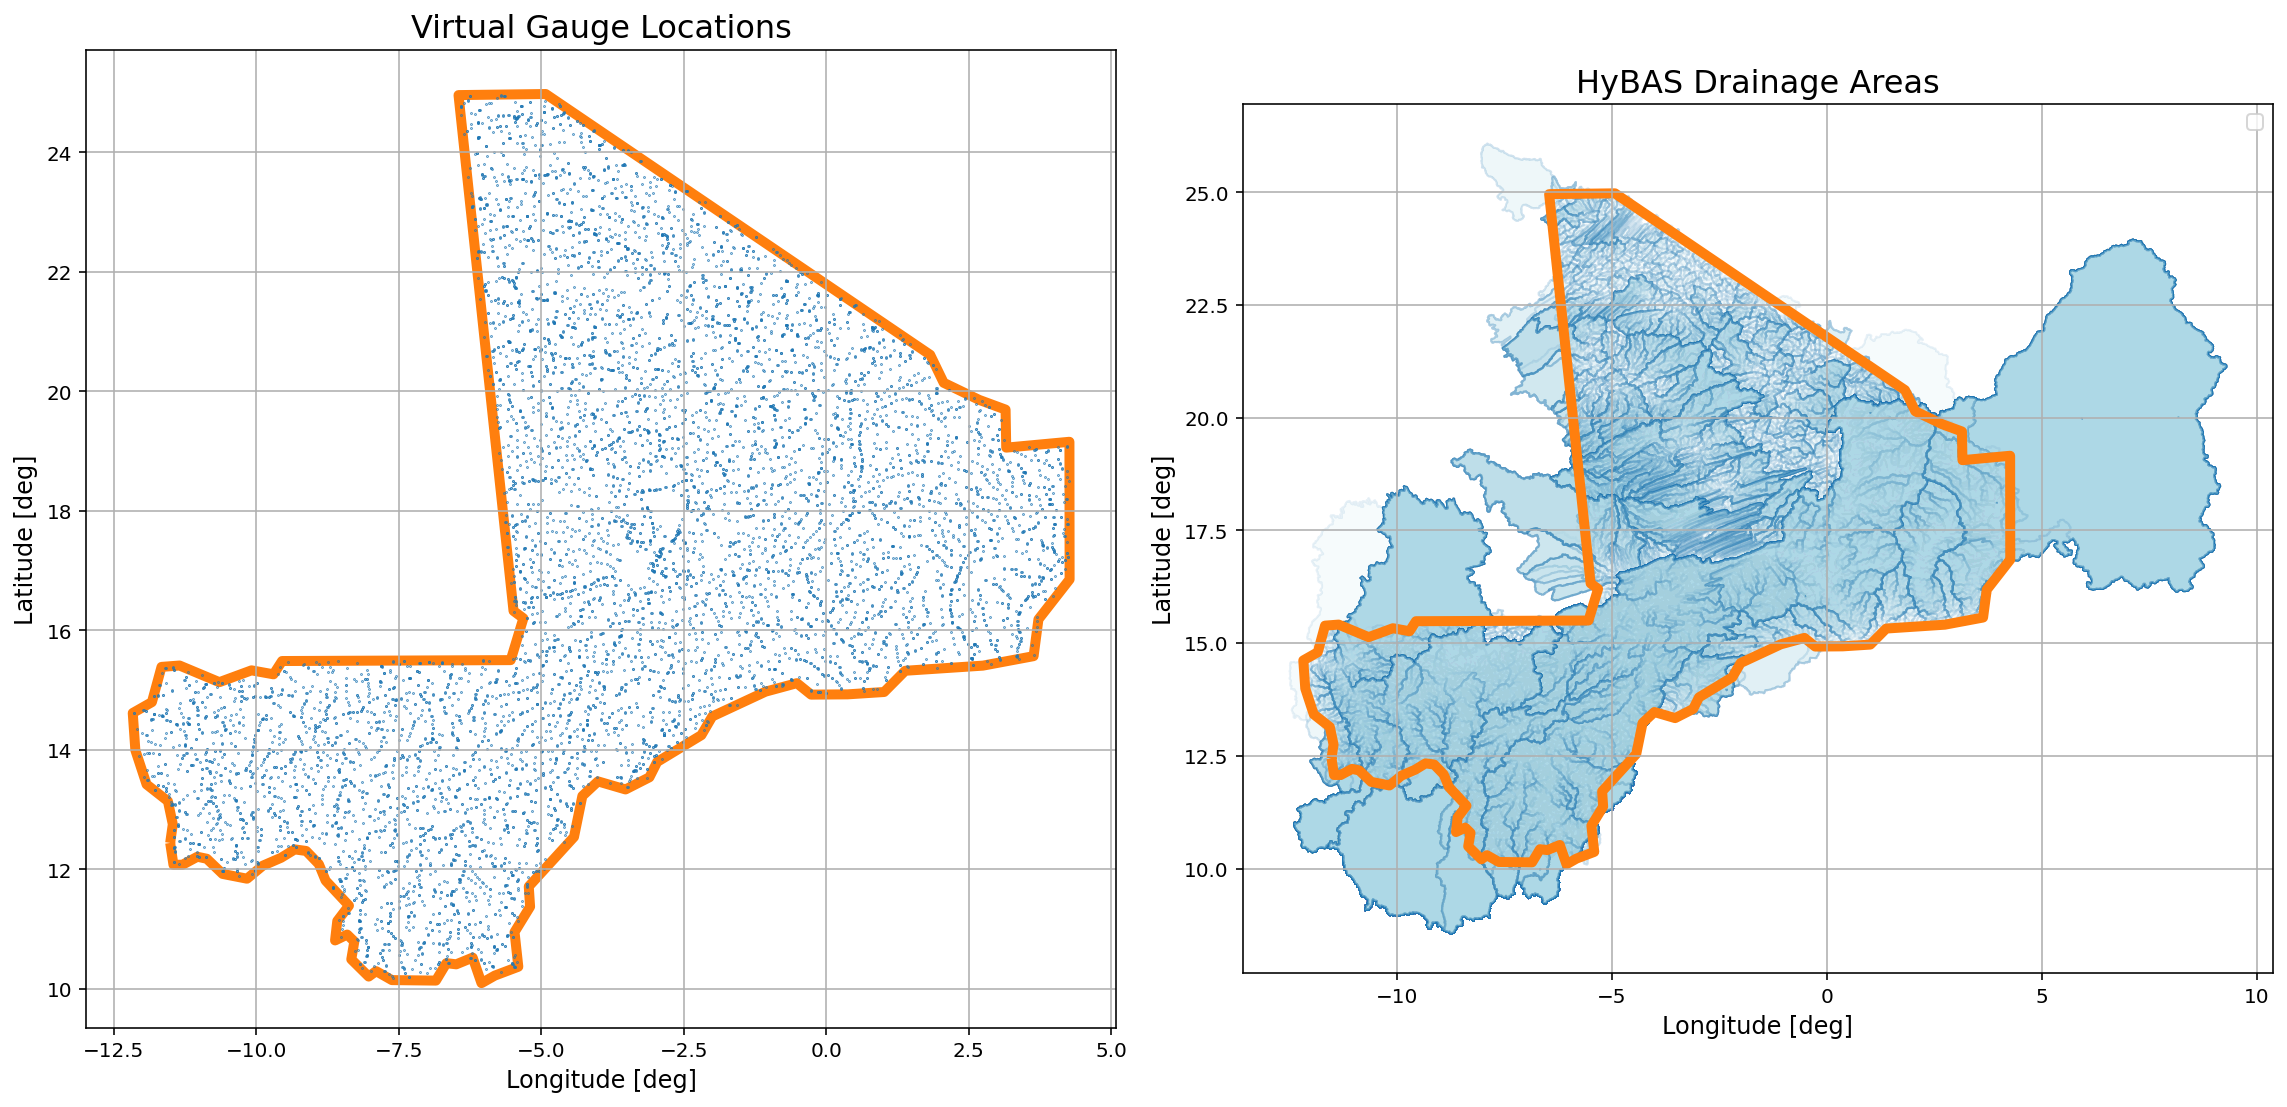

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 24))

# Plot virtual gauges.
ax = axes[0]
countries_gdf.plot(ax=ax, facecolor='none', edgecolor=colors[1], linewidth=5)
ax.set_title('Virtual Gauge Locations', fontsize=16)
ax.scatter(
    virtual_gauges_in_countries_df.loc[virtual_gauges_in_countries, 'longitude'],
    virtual_gauges_in_countries_df.loc[virtual_gauges_in_countries, 'latitude'],
    s=0.1, c=colors[0],
    # label=f'Virtual Gauges in Country or Countries ({len(virtual_gauges_in_countries)})'
)
ax.grid()
# ax.legend()
ax.set_xlabel('Longitude [deg]', fontsize=12);
ax.set_ylabel('Latitude [deg]', fontsize=12);

# Plot HyBAS drainage areas.
ax = axes[1]
hybas_drainage_polygons_in_countries_gdf.plot(
    ax=ax, facecolor='lightblue', edgecolor=colors[0], alpha=0.1, linewidth=1)
countries_gdf.plot(ax=ax, facecolor='none', edgecolor=colors[1], linewidth=5)
ax.set_title('HyBAS Drainage Areas', fontsize=16)
ax.grid()
ax.legend()
ax.set_xlabel('Longitude [deg]', fontsize=12);
ax.set_ylabel('Latitude [deg]', fontsize=12);

plt.tight_layout()
plt.show()

## Save Virtual Gauge Metadata

In [ ]:
countries_string = '_'.join(COUNTRIES_TO_EXTRACT)

# Save metadata as Pandas Dataframe: latitude, longitude, drainage area [km2].
# No drainage area polygons.
virtual_gauge_file = os.path.join(OUTPUT_SAVE_PATH, f'{countries_string}_virtual_gauges_metadata.csv')
with open_fn(virtual_gauge_file, 'wt') as f:
  virtual_gauges_in_countries_df.to_csv(f)

# Save metadata as GeoPandas GeoDataframe: latitude, longitude, drainage area [km2], and drainage area geometry.
virtual_gauge_file = os.path.join(OUTPUT_SAVE_PATH, f'{countries_string}_virtual_gauges_metadata.geojson')
with open_fn(virtual_gauge_file, 'wb') as f:
  hybas_drainage_polygons_in_countries_gdf.to_file(f, driver='GeoJSON')

# Step 2: Collocate Physical & Virtual Gauges
The user will supply a set of latitude and longitude coordinates for the locations where they require predictions. We will assume these are the locations of physical streamflow gauges.

If available, the user will also supply drainage areas for the physical gauges. Drainage areas are used to help match corresonding virtual gauges that represent approximately the same watershed(s). If drainage areas for the phyiscal gauges are not supplied, that part of the algorithm is skipped and the user is left with a larger number of candidate gauges that they must manually select from.

Notice that it is possible for a physical gauge to require summing the hydrographs from two (or more) virutal gauges. This happens when the physical gauge is located just downstream from a river join.

## User-Supplied Prediction Locations
These are locations where the user would like to have historical simulations or forecasts.

This information must be supplied as a Pandas Dataframe with the column headers: Gauge ID, Latitude, Longitude, Area. The Dataframe can be loaded from an external CSV file, or can be constructed directly here.

In [ ]:
# This data comes from you, the user.
# You can also load this in from e.g., a CSV file.
physical_gauges_df = pd.DataFrame(
    columns=['gauge_id', 'latitude', 'longitude', 'area'],
    data=[
        ['Guelelinkoro', 11.15, -8.5643, 23300],
        ['Banankoro', 11.6889801, -8.665260315, 71800],
        ['Bamako', 12.63129997, -7.998459816, 117000],
        ['Koulikoro', 12.85933304, -7.556388855, 120000],
        ['Mopti', 14.48841953, -4.205490112, 281600],
        ['Dire', 16.27916718, -3.383333206, 366500],
        ['Ansongo', 15.66493416, 0.494453013, 566000],
        ['Gao', 16.26667023, -0.050000001, 556000],
        ['Sofara', 14.01393032, -4.242899895, 129400],
        ['Douna', 13.21725178, -5.899744987, 101300],
        ['Bougouni', 11.39820957, -7.449699879, 930],
        ['Pankourou', 11.44886017, -6.576519966, 32150],
        ['Kayes', 14.45351601, -11.44, 157400],
        ['Bafing Makana', 12.55000019, -10.28333378, 21000]
    ]
).set_index('gauge_id')

physical_gauges_df.head()

,latitude,longitude,area
gauge_id,,,
Guelelinkoro,11.150000,-8.564300,23300
Banankoro,11.688980,-8.665260,71800
Bamako,12.631300,-7.998460,117000
Koulikoro,12.859333,-7.556389,120000
Mopti,14.488420,-4.205490,281600


## Candidate Virtual Gauges
Algorithmic extraction of virtual gauges that might represent the user-supplied physical gauge locations.

### Virtual Gauges within Radius

In [ ]:
# Radius in kilometers within which to search for candidate virtual gauges
# around each physical gauge.
VIRTUAL_GAUGE_SEARCH_RADIUS_KM = 10

In [ ]:
# Helper code.
def find_points_within_distance(df1, df2, distance_km):
  """
  Finds points in df2 that are within a specified distance of each point in df1.

  Args:
    df1 (pd.DataFrame): DataFrame with latitude and longitude columns.
    df2 (pd.DataFrame): DataFrame with latitude and longitude columns.
    distance_km (float): The distance threshold in kilometers.

  Returns:
    dict: A dictionary where keys are indices from df1, and values are lists of
          indices from df2 that are within the specified distance.
  """

  results = {}
  distances = {}

  for idx1, row1 in tqdm.tqdm(df1.iterrows()):
    lat1, lon1 = row1['latitude'], row1['longitude']
    point1 = (lat1, lon1)
    nearby_points = []
    nearby_distances = []

    for idx2, row2 in df2.iterrows():
      lat2, lon2 = row2['latitude'], row2['longitude']
      point2 = (lat2, lon2)

      dist = geodesic(point1, point2).kilometers
      if dist <= distance_km:
        nearby_points.append(idx2)
        nearby_distances.append(dist)

    results[idx1] = nearby_points
    distances[idx1] = nearby_distances

  return results, distances

In [ ]:
# Find virtual gauges within search radius.
virtual_gauges_within_radius, radius_candidate_distances = find_points_within_distance(
    physical_gauges_df,
    virtual_gauges_in_countries_df.loc[virtual_gauges_in_countries],
    VIRTUAL_GAUGE_SEARCH_RADIUS_KM
)

# Check for physical gauges with zero candidate virtual gauges.
zero_candidates = [key for key, value in virtual_gauges_within_radius.items() if len(value) == 0]
if zero_candidates:
  print(f"Physical gauges with zero candidate virtual gauges: {zero_candidates}")
  print('Suggest increasing the search radius.')
else:
  print("No physical gauges have zero candidate virtual gauges.")

No physical gauges have zero candidate virtual gauges.


<ipython-input-50-b9297c2a731d>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-50-b9297c2a731d>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


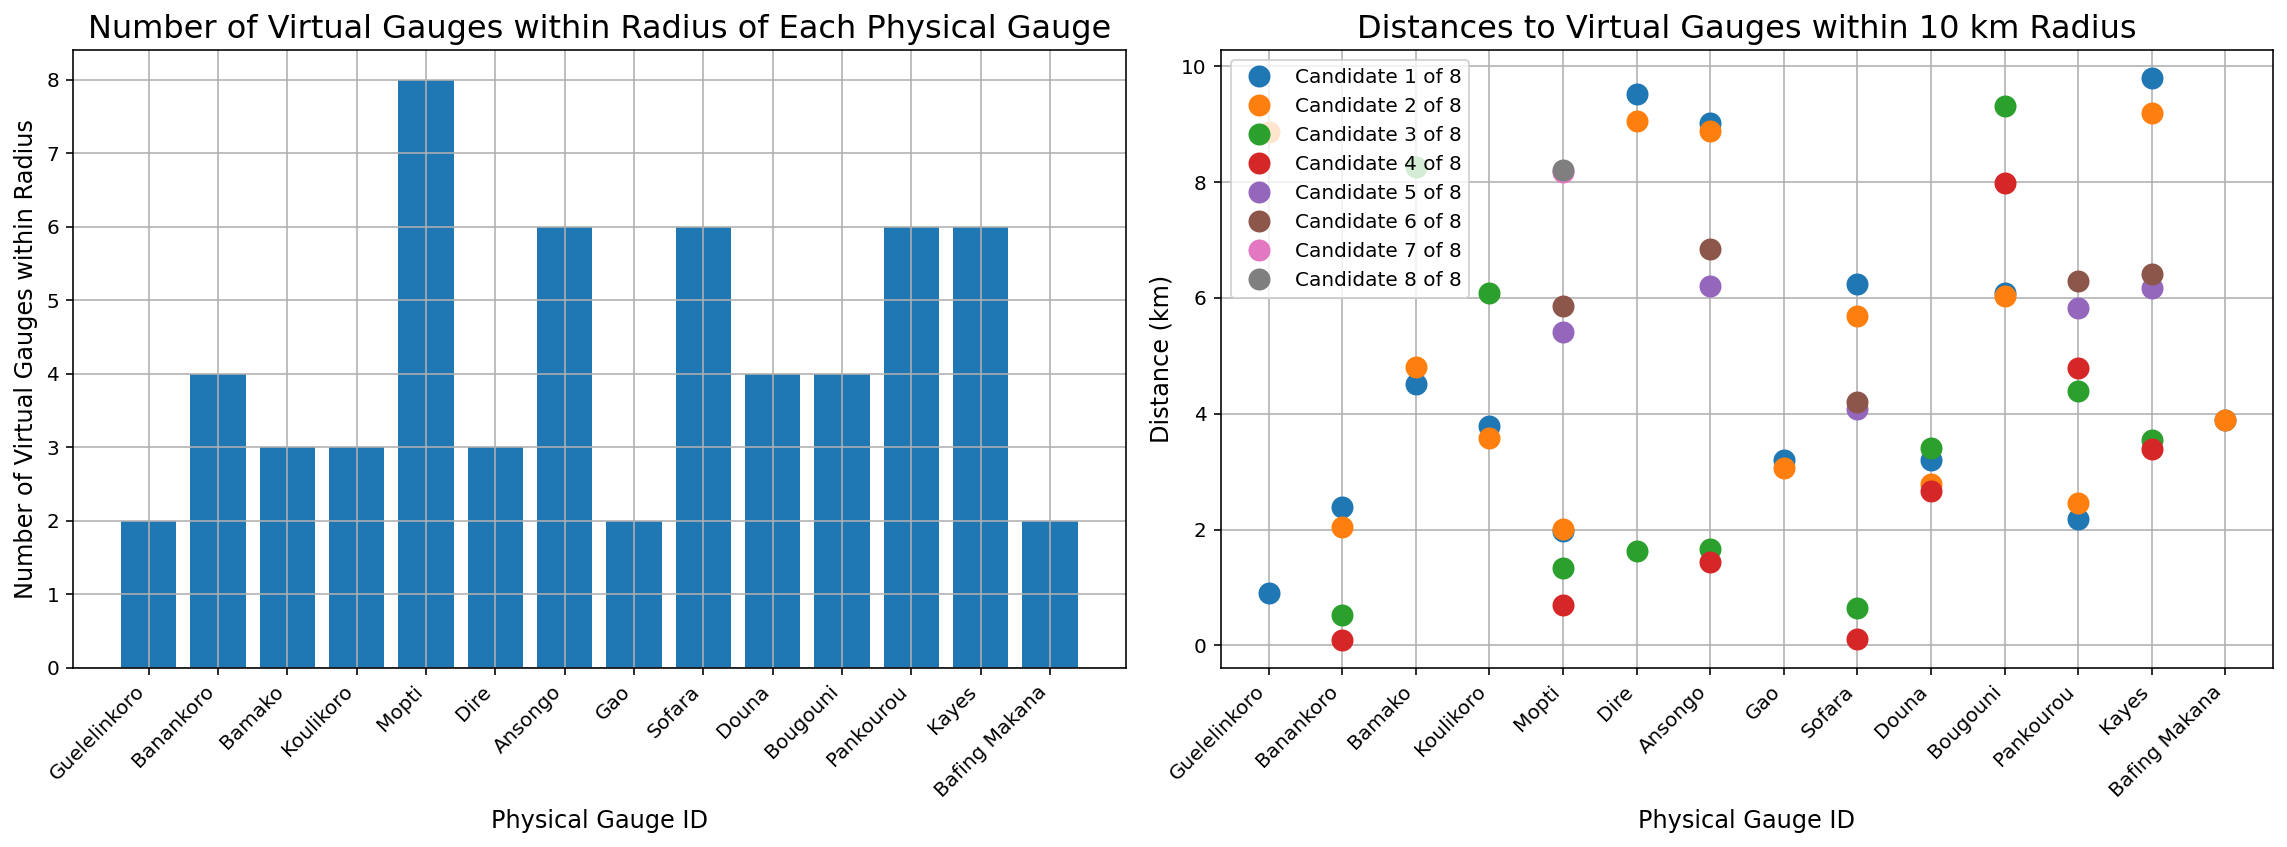

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot counts of gauges found with radius method.
ax = axes[0]
radius_list_lengths = [len(value) for value in virtual_gauges_within_radius.values()]
gauge_ids = list(virtual_gauges_within_radius.keys())
ax.bar(gauge_ids, radius_list_lengths)
ax.grid()
ax.set_xlabel('Physical Gauge ID', fontsize=12)
ax.set_ylabel('Number of Virtual Gauges within Radius', fontsize=12)
ax.set_title('Number of Virtual Gauges within Radius of Each Physical Gauge', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Plot distances to candidate virtual gauges selected by the radius method.
ax = axes[1]
max_key = max(
    radius_candidate_distances,
    key=lambda k: len(radius_candidate_distances[k])
    if isinstance(radius_candidate_distances[k], list) else 0
)
for gauge_id, distances in radius_candidate_distances.items():
  for idx, distance in enumerate(distances):
    if gauge_id == max_key:
      ax.plot(gauge_id, distance, 'o', markersize=10, color=colors[idx], label=f'Candidate {idx+1} of {len(distances)}')
    else:
      ax.plot(gauge_id, distance, 'o', markersize=10, color=colors[idx])
ax.set_xlabel('Physical Gauge ID', fontsize=12)
ax.set_ylabel('Distance (km)', fontsize=12)
ax.set_title(f'Distances to Virtual Gauges within {VIRTUAL_GAUGE_SEARCH_RADIUS_KM} km Radius', fontsize=16)
ax.grid(True)
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Aesthetics.
plt.tight_layout()
plt.show()

### N-Nearest Neighbor Virtual Gauges



In [ ]:
# Number of closest virtual gauges to find for each physical gauge.
N_CLOSEST_VIRTUAL_GAUGES = 3

In [ ]:
def find_n_closest_points(df1, df2, n=3):
  """
  Finds the N closest points in df2 to each point in df1.

  Args:
    df1: DataFrame with 'latitude' and 'longitude' columns.
    df2: DataFrame with 'latitude' and 'longitude' columns.
    n: The number of closest points to find.

  Returns:
    dict: A dictionary where keys are indices from df1, and values are lists of
          the N closest indices from df2.
  """

  closest_points = {}
  closest_distances = {}

  for index1, row1 in tqdm.tqdm(df1.iterrows()):
    distances = []
    for index2, row2 in df2.iterrows():
      point1 = (row1['latitude'], row1['longitude'])
      point2 = (row2['latitude'], row2['longitude'])
      distances.append((geodesic(point1, point2).kilometers, index2))
    distances.sort()
    closest_points[index1] = [index for _, index in distances[:n]]
    closest_distances[index1] = [distance for distance, _ in distances[:n]]

  return closest_points, closest_distances

In [ ]:
# Find neighbor virtual gauges to each physical gauge.
closest_virtual_gauges, closest_candidate_distances = find_n_closest_points(
    physical_gauges_df,
    virtual_gauges_in_countries_df,
    N_CLOSEST_VIRTUAL_GAUGES
)

<ipython-input-54-5214182e72cd>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-54-5214182e72cd>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


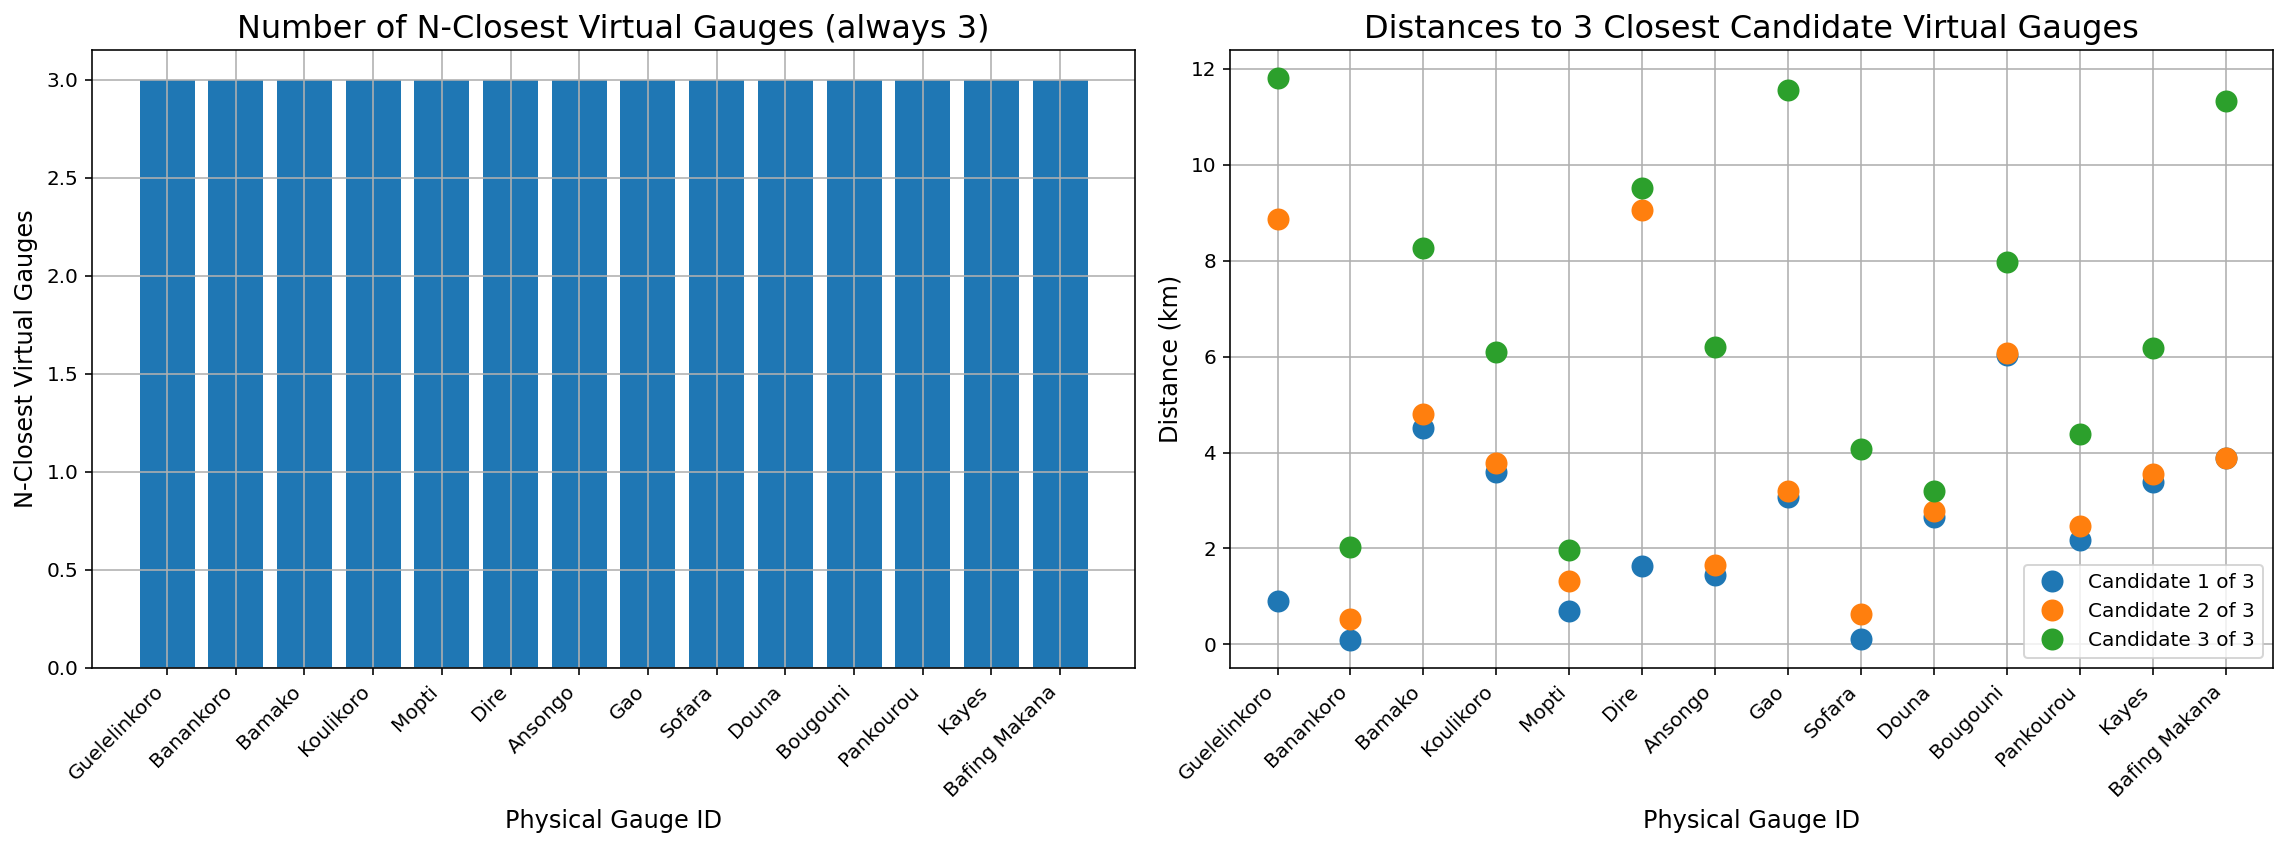

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot counts of gauges found with nearest neighbor method.
ax = axes[0]
neighbor_list_lengths = [len(value) for value in closest_virtual_gauges.values()]
gauge_ids = list(closest_virtual_gauges.keys())
ax.bar(gauge_ids, neighbor_list_lengths)
ax.grid()
ax.set_xlabel('Physical Gauge ID', fontsize=12)
ax.set_ylabel('N-Closest Virtual Gauges', fontsize=12)
ax.set_title(f'Number of N-Closest Virtual Gauges (always {N_CLOSEST_VIRTUAL_GAUGES})', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Plot distances to candidate gauges selected by the nearest neighbor method.
ax = axes[1]
for gauge_idx, (gauge_id, distances) in enumerate(closest_candidate_distances.items()):
  for idx, distance in enumerate(distances):
    if gauge_idx == 0:
      ax.plot(gauge_id, distance, 'o', markersize=10, color=colors[idx], label=f'Candidate {idx+1} of {len(distances)}')
    else:
      ax.plot(gauge_id, distance, 'o', markersize=10, color=colors[idx])
ax.set_xlabel('Physical Gauge ID', fontsize=12)
ax.set_ylabel('Distance (km)', fontsize=12)
ax.set_title(f'Distances to {N_CLOSEST_VIRTUAL_GAUGES} Closest Candidate Virtual Gauges', fontsize=16)
ax.grid(True)
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Aesthetics.
plt.tight_layout()
plt.show()

### Automated Selection Algorithm

In [ ]:
# Fractional difference between physical drainage area and virtal gauge area(s)
# that is considered to be acceptable. This is a user-specified parameter,
# and any result you get from using this algorithm should be checked manually
# using the visualization tools supplied below.
DRAINAGE_AREA_THRESHOLD = 0.1

In [ ]:
def remove_overlapping_polygons(polygon_mapping, min_overlap_threshold=0.1):
  """
  Removes overlapping polygons from a list, prioritizing larger polygons.

  Args:
    polygon_mapping: A dictionary mapping polygon IDs to
      shapely.geometry.Polygon objects.
    min_overlap_threshold: The minimum overlap area fraction (between 0 and 1)
      required for two polygons to be considered overlapping.

  Returns:
      A list of polygon IDs after removing overlapping polygons.
  """

  polygon_ids = list(polygon_mapping.keys())
  filtered_ids = []

  while polygon_ids:
    current_id = polygon_ids.pop(0)
    current_polygon = polygon_mapping[current_id]

    to_remove = []
    for other_id in polygon_ids:
      other_polygon = polygon_mapping[other_id]
      intersection_area = current_polygon.intersection(other_polygon).area

      if intersection_area > 0:
        current_area = current_polygon.area
        other_area = other_polygon.area
        overlap_fraction_current = intersection_area / current_area
        overlap_fraction_other = intersection_area / other_area

        if overlap_fraction_current >= min_overlap_threshold or overlap_fraction_other >= min_overlap_threshold:
          if current_area >= other_area:
            to_remove.append(other_id)
          else:
            to_remove.append(current_id)
            current_id = other_id
            current_polygon = polygon_mapping[current_id]
            break

    # remove other_id from list before proceeding to the next current_id
    polygon_ids = [id_ for id_ in polygon_ids if id_ not in to_remove]

    filtered_ids.append(current_id)

  return filtered_ids


def gauge_match_by_area(
    physical_gauge_area,
    candidate_gauge_polygons,
    candidate_gauge_areas,
):
  """
  Finds the virtual gauge or combination with the closest drainage area.

  Args:
    physical_gauge_area: The physical gauge's drainage area.
    candidate_gauge_polygons: A mapping from gauge ID to drainage area polygons.
    candidate_gauge_areas: A mapping from gauge ID to drainage area.

  Returns:
    A tuple: (List of gauges contributing to the closest area match,
      the area difference fraction) or None if no suitable match is found within
      the threshold.
  """
  best_match = None
  min_diff = float('inf')

  # Test individual gauges
  for gauge, area in candidate_gauge_areas.items():
    diff = abs(physical_gauge_area - area)
    if diff < min_diff:
      min_diff = diff
      best_match = [gauge]

  # Test combinations of virtual gauges
  candidate_gauges = list(candidate_gauge_areas.keys())
  for i in range(1 << len(candidate_gauge_areas)):
    combination_area = 0
    combination_ids = []
    for j in range(len(candidate_gauge_areas)):
      if (i >> j) & 1:
        combination_area += candidate_gauge_areas[candidate_gauges[j]]
        combination_ids.append(candidate_gauges[j])

    if combination_ids:
      combination_ids = remove_overlapping_polygons(
          {id: candidate_gauge_polygons[id] for id in combination_ids})
      combination_area = sum(
          [candidate_gauge_areas[id] for id in combination_ids])
      diff = abs(physical_gauge_area - combination_area)
      if diff < min_diff:
        min_diff = diff
        best_match = combination_ids

  if min_diff <= DRAINAGE_AREA_THRESHOLD * physical_gauge_area:
    return best_match, min_diff / physical_gauge_area
  else:
    return None

In [ ]:
# Run the algorithmic matching for all physical gauges.
algorithmic_virtual_gauges = {}
area_difference_fraction = {}

for physical_gauge_id, row in physical_gauges_df.iterrows():
  match_result = gauge_match_by_area(
      physical_gauge_area=row['area'],
      candidate_gauge_areas={
          id: virtual_gauges_in_countries_df.loc[id, 'area']
          for id in virtual_gauges_within_radius[physical_gauge_id]
      },
      candidate_gauge_polygons={
          id: hybas_drainage_polygons_in_countries_gdf.loc[
              id, GPD_GEOMETRY_COLUMN_HEADER]
          for id in virtual_gauges_within_radius[physical_gauge_id]
      }
  )
  if match_result:
    best_match_gauges, area_diff = match_result
    algorithmic_virtual_gauges[physical_gauge_id] = best_match_gauges
    area_difference_fraction[physical_gauge_id] = area_diff
  else:
    print(f"No suitable match found for physical gauge {physical_gauge_id}")
    algorithmic_virtual_gauges[physical_gauge_id] = []
    area_difference_fraction[physical_gauge_id] = None

# Summarize results.
num_gauges_without_match = sum(1 for value in algorithmic_virtual_gauges.values() if not value)
print(f'Number of gauges without a match: {num_gauges_without_match}.')
max_area_diff_frac = max(area_difference_fraction.values())
min_area_diff_frac = min(area_difference_fraction.values())
print(f'Minimum area difference fraction: {min_area_diff_frac:.3f}.')
print(f'Maximum area difference fraction: {max_area_diff_frac:.3f}.')

Number of gauges without a match: 0.
Minimum area difference fraction: 0.000.
Maximum area difference fraction: 0.070.


<ipython-input-137-71ab7fac9f14>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-137-71ab7fac9f14>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-137-71ab7fac9f14>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


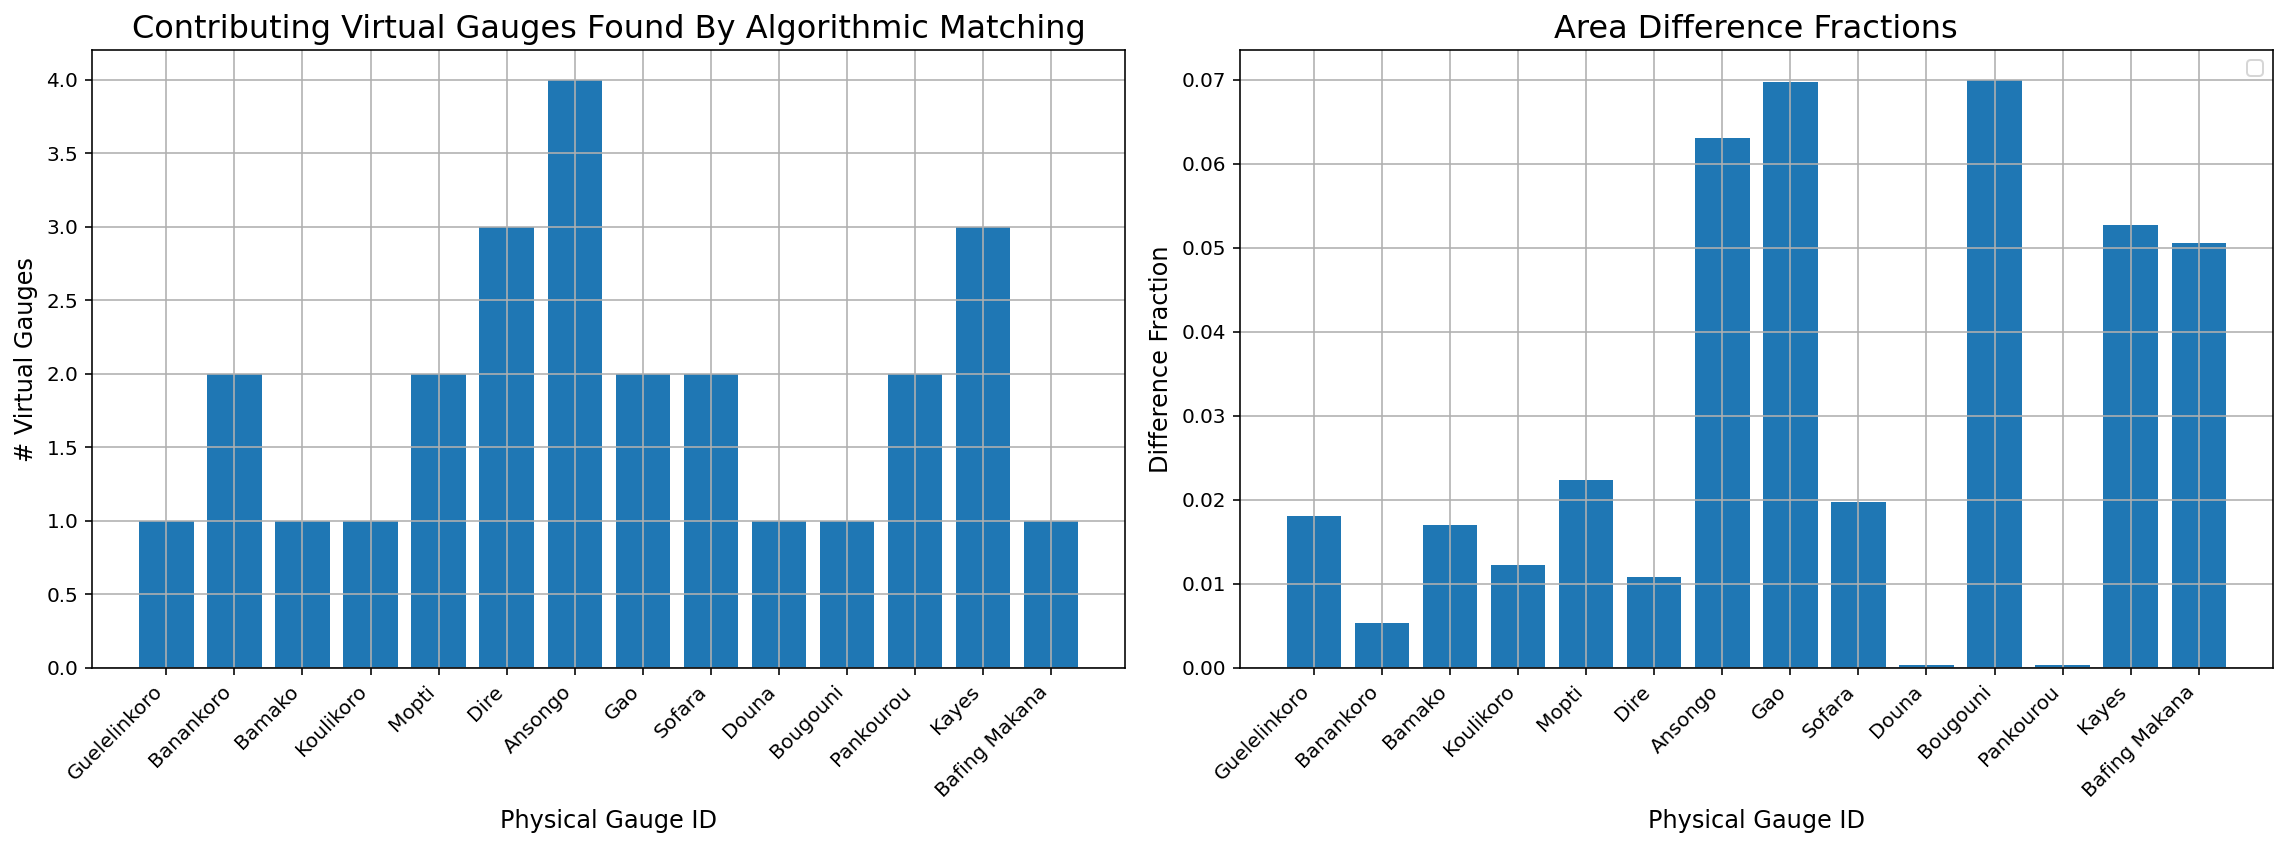

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot counts of gauges found with algorithm method.
ax = axes[0]
neighbor_list_lengths = [
    len(value) for value in algorithmic_virtual_gauges.values()]
gauge_ids = list(algorithmic_virtual_gauges.keys())
ax.bar(gauge_ids, neighbor_list_lengths)
ax.grid()
ax.set_xlabel('Physical Gauge ID', fontsize=12)
ax.set_ylabel('# Virtual Gauges', fontsize=12)
ax.set_title(f'Contributing Virtual Gauges Found By Algorithmic Matching', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Plot area difference fractions.
ax = axes[1]
ax.bar(
    area_difference_fraction.keys(),
    area_difference_fraction.values(),
)
ax.set_xlabel('Physical Gauge ID', fontsize=12)
ax.set_ylabel('Difference Fraction', fontsize=12)
ax.set_title(f'Area Difference Fractions', fontsize=16)
ax.grid(True)
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Aesthetics.
plt.tight_layout()
plt.show()

## Visual Inspection
Tools to help the user visually inspect local geography and manually choose the best virtual gauge locations for each physical gauge.

In [ ]:
# Helper code.
def calculate_max_zoom(physical_gauges_df):
  """Calculates the maximum folium map zoom to capture all points."""

  if physical_gauges_df.shape[0] == 1:
    return 15

  # Check if latitude and longitude columns exist
  if not all(col in physical_gauges_df.columns for col in ['latitude', 'longitude']):
    raise ValueError("DataFrame must contain 'latitude' and 'longitude' columns.")

  # Calculate bounds
  min_lat = physical_gauges_df['latitude'].min()
  max_lat = physical_gauges_df['latitude'].max()
  min_lon = physical_gauges_df['longitude'].min()
  max_lon = physical_gauges_df['longitude'].max()


  # Estimate zoom level (adjust constants as needed)
  lat_diff = max_lat - min_lat
  lon_diff = max_lon - min_lon
  max_diff = max(lat_diff, lon_diff)

  # Approximation, adjust constants if needed
  zoom_level = 12 - np.log2(max_diff)
  zoom_level = int(zoom_level)

  # Set a lower limit for the zoom level
  zoom_level = max(zoom_level, 1)

  return zoom_level - 0.5

In [ ]:
_SIMPLIFICATION_TOLERANCE = 0.001

basemap = folium.TileLayer(
    tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr = 'Google',
    name = 'Google Satellite',
    overlay = True,
    control = True
)

def make_map(
    basemap: folium.TileLayer = basemap,
    height: int = 1000,
    width: str = '100%',
    center_lat: float = 0,
    center_lng: float = 0,
    zoom: int = 2,
) -> folium.Map:
  """Builds a folium map.

  Args:
    height: The height of the div in pixels.
    width: The width of the div as a string, e.g. '100%' or '500px'.
    basemap: A map tileset to use. Common ones are in `folium_utils.BASEMAPS`.
      For more: https://leaflet-extras.github.io/leaflet-providers/preview/ .
    center_lat: Latitude of the initial center of the map.
    center_lng: Longitude of the initial center of the map.
    zoom: An initial zoom level for the map, between 0 and 18.

  Returns:
    A folium Map object, that can be used to draw markers and polygons, and be
    displayed in Colab.
  """
  fig = branca.element.Figure(height=height, width=width)

  my_map = folium.Map(location=(center_lat, center_lng), zoom_start=zoom)
  my_map.add_child(basemap)
  my_map.add_child(folium.plugins.MousePosition())
  my_map.add_child(folium.plugins.MeasureControl())
  my_map.add_child(folium.plugins.Draw())
  my_map.add_child(folium.LatLngPopup())

  fig.add_child(my_map)
  return my_map


def _shapely_to_folium_polygon(
    polygon: Polygon,
    color: str = 'blue',
    weight: float = 2,
    opacity: float = 0.8,
    fill_opacity: float = 0.2,
) -> folium.GeoJson:
  """Converts a shapely polygon to a folium polygon with style settings."""
  simple_polygon = polygon.simplify(tolerance=_SIMPLIFICATION_TOLERANCE)
  polygon_json = gpd.GeoSeries(simple_polygon).to_json()
  style = {
      'fillColor': color,
      'color': color,
      'weight': weight,
      'opacity': opacity,
      'fillOpacity': fill_opacity,
  }
  return folium.GeoJson(data=polygon_json, style_function=lambda _: style)


def add_polygon_to_map(
    polygon: Polygon,
    map_object: folium.Map,
    color: str = 'blue',
    weight: float = 2,
    opacity: float = 0.8,
    fill_opacity: float = 0.2,
    name: str = '',
    area: float | None = None,
):
  """Plots a polygon on a folium map."""
  polygon_json = _shapely_to_folium_polygon(
      polygon, color, weight, opacity, fill_opacity
  )
  title = name
  if area is not None:
    title += f' area={area:.2f}'
  if title:
    folium.Popup(title).add_to(polygon_json)
  if name is not None:
    group = folium.FeatureGroup(f'polygon {name}')
    polygon_json.add_to(group)
    group.add_to(map_object)
  else:
    polygon_json.add_to(map_object)


def add_marker_to_map(
    longitude: float,
    latitude: float,
    map_object: folium.Map,
    name: str | None = None,
    metadata: str | None = None,
    color: str = 'blue',
    icon_name: str = 'info-sign',
):
  """Plots a marker on a folium map."""
  tooltip = ''
  if name is not None:
    tooltip = name
  if metadata is not None:
    tooltip += f' {metadata}'
  if not tooltip:
    tooltip = None
  icon = folium.Icon(icon=icon_name, prefix='fa', color=color)
  marker = folium.Marker(
      location=(latitude, longitude),
      tooltip=tooltip,
      icon=icon,
  )
  if name is not None:
    group = folium.FeatureGroup(f'marker {name}')
    marker.add_to(group)
    group.add_to(map_object)
  else:
    marker.add_to(map_object)

###Plot All Physical & Candidate Gauges

In [ ]:
method_selection = widgets.Dropdown(
    options=['Nearest Neighbor', 'Radius', 'Algorithmic'],
    value='Nearest Neighbor',
    description='Select Method:'
)

def on_method_change(change):
  global candidate_virtual_gauges
  selected_method = change.new
  print(f"Selected method: {selected_method}")

  if selected_method == 'Nearest Neighbor':
    candidate_virtual_gauges = closest_virtual_gauges
  elif selected_method == 'Radius':
    candidate_virtual_gauges = virtual_gauges_within_radius
  elif selected_method == 'Algorithmic':
    candidate_virtual_gauges = algorithmic_virtual_gauges
  else:
    candidate_virtual_gauges = None

  print(f"Candidate virtual gauges updated with {selected_method} method.")

method_selection.observe(on_method_change, names='value')
display(method_selection)


Dropdown(description='Select Method:', options=('Nearest Neighbor', 'Radius', 'Algorithmic'), value='Nearest N…

Selected method: Algorithmic
Candidate virtual gauges updated with Algorithmic method.
Selected method: Nearest Neighbor
Candidate virtual gauges updated with Nearest Neighbor method.
Selected method: Radius
Candidate virtual gauges updated with Radius method.
Selected method: Nearest Neighbor
Candidate virtual gauges updated with Nearest Neighbor method.


In [ ]:
# Calculate the plotting hyperparameters: scale and center.
longitude_center = physical_gauges_df['longitude'].mean()
latitude_center = physical_gauges_df['latitude'].mean()
default_zoom = calculate_max_zoom(physical_gauges_df)

# Initialize the map.
basin_map = make_map(
    height=1000,
    center_lat=latitude_center,
    center_lng=longitude_center ,
    zoom=default_zoom,
    basemap=basemap
)

# Loop through all physical gauges.
for physical_gauge, physical_row in physical_gauges_df.iterrows():
  add_marker_to_map(
      longitude=physical_row['longitude'],
      latitude=physical_row['latitude'],
      map_object=basin_map,
      name=physical_gauge,
      color='red'
  )

  # Plot all virtual gauge candidates for each physical gauge.
  for virtual_gauge, virtual_row in virtual_gauges_in_countries_df.loc[candidate_virtual_gauges[physical_gauge]].iterrows():
    add_marker_to_map(
        longitude=virtual_row['longitude'],
        latitude=virtual_row['latitude'],
        map_object=basin_map,
        name=virtual_gauge,
        color='blue'
    )

# Display the map.
basin_map.add_child(folium.LayerControl())

### Inspect Individual Gauges

In [ ]:
# Pick a single physical gauge to work with.
gauge_options = list(physical_gauges_df.index)
selected_gauge = widgets.Dropdown(
    options=gauge_options,
    value=gauge_options[0],
    description='Select Gauge:',
)

def on_gauge_change(change):
  global chosen_gauge
  chosen_gauge = change.new
  print(f'Selected Gauge: {chosen_gauge}')

selected_gauge.observe(on_gauge_change, names='value')
display(selected_gauge)

Dropdown(description='Select Gauge:', options=('Guelelinkoro', 'Banankoro', 'Bamako', 'Koulikoro', 'Mopti', 'D…

Selected Gauge: Banankoro
Selected Gauge: Mopti
Selected Gauge: Guelelinkoro
Selected Gauge: Banankoro
Selected Gauge: Bamako
Selected Gauge: Koulikoro
Selected Gauge: Dire
Selected Gauge: Ansongo
Selected Gauge: Gao
Selected Gauge: Sofara
Selected Gauge: Douna
Selected Gauge: Bougouni
Selected Gauge: Pankourou
Selected Gauge: Kayes
Selected Gauge: Bafing Makana
Selected Gauge: Bougouni


In [ ]:
print(f'The user-supplied drainage area for gauge {chosen_gauge} is {physical_gauges_df.loc[chosen_gauge, "area"]}')
for candidate_gauge in candidate_virtual_gauges[chosen_gauge]:
  print(f'The user-supplied drainage area for gauge {candidate_gauge} is {virtual_gauges_in_countries_df.loc[candidate_gauge, "area"]}')

The user-supplied drainage area for gauge Bougouni is 930
The user-supplied drainage area for gauge hybas_1120761280 is 246.4
The user-supplied drainage area for gauge hybas_1120761040 is 14698.4
The user-supplied drainage area for gauge hybas_1121935350 is 15122.7


In [ ]:
# Calculate the plotting hyperparameters: scale and center.
longitude_center = physical_gauges_df.loc[chosen_gauge, 'longitude']
latitude_center = physical_gauges_df.loc[chosen_gauge, 'latitude']
default_zoom = calculate_max_zoom(virtual_gauges_in_countries_df.loc[candidate_virtual_gauges[chosen_gauge]]) - 2


# Initialize the map.
basin_map = make_map(
    height=1000,
    center_lat=latitude_center,
    center_lng=longitude_center ,
    zoom=default_zoom,
    basemap=basemap
)

# Add the selected physical gauge to the map.
add_marker_to_map(
    longitude=physical_gauges_df.loc[chosen_gauge, 'longitude'],
    latitude=physical_gauges_df.loc[chosen_gauge, 'latitude'],
    map_object=basin_map,
    name=chosen_gauge,
    color='red'
)

# Plot all virtual gauge candidates for the selected physical gauge.
for virtual_gauge, virtual_row in virtual_gauges_in_countries_df.loc[candidate_virtual_gauges[chosen_gauge]].iterrows():
  add_marker_to_map(
      longitude=virtual_row['longitude'],
      latitude=virtual_row['latitude'],
      map_object=basin_map,
      name=virtual_gauge,
      color='blue'
  )

# Plot drainage areas.
for virtual_gauge, gdf in hybas_drainage_polygons_in_countries_gdf.loc[
    candidate_virtual_gauges[chosen_gauge]].iterrows():
  add_polygon_to_map(
      polygon=gdf['geometry'],
      map_object=basin_map,
      weight=1.0,
      color='blue',
      name=virtual_gauge
  )

# Display the map.
basin_map.add_child(folium.LayerControl())

### Hand-Input Results from Visual Inspection

In [ ]:
# Create a mapping here from each physical gauge to a list of virtual gauges that
# contribute to streamflow at the physical gauge location.
# This can be more than one virtual gauge.
# The hydrograph loading routines below will sum hydrographs from all virtual
# gauges in the list of contributing gauges separately for each physical gauge.
CONTRIBUTING_VIRTUAL_GAUGES = {
    'Guelelinkoro': ['hybas_1121939410'],
    'Banankoro': ['hybas_1120748210'],
    'Bamako': ['hybas_1121916250'],
    'Koulikoro': ['hybas_1121912140'],
    'Mopti': ['hybas_1120641660', 'hybas_1120641670'],
    'Dire': ['hybas_1121862050'],
    'Ansongo': ['hybas_1120599600', 'hybas_1120599610'],
    'Gao': ['hybas_1120577750', 'hybas_1120577760'],
    'Sofara': ['hybas_1120658110'],
    'Douna': ['hybas_1120690110'],
    'Bougouni': ['hybas_1121935350'],  # I wonder whether the drainage area supplied here is correct?
    'Pankourou': ['hybas_1120758950', 'gauge hybas_1120758780'],
    'Kayes': ['hybas_1120644460', 'hybas_1120644920'],
    'Bafing Makana': ['hybas_1120713990'],
}

# Step 3: Extract Predictions for Physical Gauges

In [ ]:
# Helper code.
def extract_variables_for_gauge_list(
    gauge_list,
    ds,
    variables,
):
  """
  Extracts variables for each gauge_id and sums them.

  Args:
    gauge_list: A list of gauge IDs.
    ds: The xarray dataset containing variables data.
    variables: A list of variable names to extract.

  Returns:
    An xarray DataArray of summed variables values.
  """
  extracted_dss = []
  for gauge in gauge_list:
    extracted_ds = ds.sel(gauge_id=gauge)[variables]
    extracted_dss.append(extracted_ds)

  # Concatenate variables DataArrays along the gauge_id dimension
  combined_ds = xr.concat(extracted_dss, dim='gauge_id')

  # Sum along the gauge_id dimension to get a single DataArray
  summed_ds = combined_ds.sum(dim='gauge_id')

  return summed_ds

## Extract & Save Reanalyses

In [ ]:
grrr_reanalysis_path = os.path.join(grrr_base_directory, 'reanalysis/streamflow.zarr/')
grrr_reanalysis_ds = open_zarr(grrr_reanalysis_path)
print(f'{grrr_reanalysis_ds.sizes = }')

grrr_reanalysis_ds.sizes = Frozen({'gauge_id': 1031646, 'time': 16063})


In [ ]:
streamflow_das = []
for physical_gauge, virtual_gauges in candidate_virtual_gauges.items():
  da = extract_variables_for_gauge_list(
      gauge_list=virtual_gauges,
      ds=grrr_reanalysis_ds,
      variables=['streamflow']
  )
  da = da.assign_coords(gauge_id=physical_gauge)
  streamflow_das.append(da)

# Concatenate all the DataArrays along the new 'gauge_id' dimension
extracted_reanalysis_ds = xr.concat(streamflow_das, dim='gauge_id')
print(f'{extracted_reanalysis_ds.sizes = }')

extracted_reanalysis_ds.sizes = Frozen({'gauge_id': 14, 'time': 16063})


In [ ]:
# Save the reanalysis data extracted for all virtual gauges.
extracted_reanalysis_save_path = os.path.join(OUTPUT_SAVE_PATH, f'{countries_string}_extracted_reanalysis.nc')
with open_fn(extracted_reanalysis_save_path, 'wb') as f:
  extracted_reanalysis_ds.to_netcdf(f)

## Extract & Save Reforecasts

In [ ]:
grrr_reforecast_path = os.path.join(grrr_base_directory, 'reforecast/streamflow.zarr/')
grrr_reforecast_ds = open_zarr(grrr_reforecast_path)
print(f'{grrr_reforecast_ds.sizes = }')

<ipython-input-8-40aee1148fbd>:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(store=path, chunks=None)


grrr_reforecast_ds.sizes = Frozen({'gauge_id': 1031646, 'issue_time': 2738, 'lead_time': 8})


In [ ]:
streamflow_das = []
for physical_gauge, virtual_gauges in candidate_virtual_gauges.items():
  da = extract_variables_for_gauge_list(
      gauge_list=virtual_gauges,
      ds=grrr_reforecast_ds,
      variables=['streamflow']
  )
  da = da.assign_coords(gauge_id=physical_gauge)
  streamflow_das.append(da)

# Concatenate all the DataArrays along the new 'gauge_id' dimension
extracted_reforecast_ds = xr.concat(streamflow_das, dim='gauge_id')
print(f'{extracted_reforecast_ds.sizes = }')

extracted_reforecast_ds.sizes = Frozen({'gauge_id': 14, 'issue_time': 2738, 'lead_time': 8})


In [ ]:
# Save the reforecast data extracted for all virtual gauges.
extracted_reforecast_save_path = os.path.join(OUTPUT_SAVE_PATH, f'{countries_string}_extracted_reforecasts.nc')
with open_fn(extracted_reforecast_save_path, 'wb') as f:
  extracted_reforecast_ds.to_netcdf(f)

#Step 4: Recalculate Return Periods
It is necessary to recalculate return period flow values in cases where we sum the hydrographs from several virtual gauges.

At the moment, we will only approximate this by summing the return period flow values from all virtual gauges. This removes any requirements for the backend code necessary to calculate return periods.

This should be fixed in future versions.

TODO: Recalculate return periods instead of summing.

In [ ]:
grrr_return_periods_path = os.path.join(grrr_base_directory, 'return_periods.zarr/')
grrr_return_periods_ds = open_zarr(grrr_return_periods_path)
print(f'{grrr_return_periods_ds.sizes = }')

grrr_return_periods_ds.sizes = Frozen({'gauge_id': 1031646})


In [ ]:
return_period_das = []
for physical_gauge, virtual_gauges in candidate_virtual_gauges.items():
  da = extract_variables_for_gauge_list(
      gauge_list=virtual_gauges,
      ds=grrr_return_periods_ds,
      variables=list(grrr_return_periods_ds.data_vars)
  )
  da = da.assign_coords(gauge_id=physical_gauge)
  return_period_das.append(da)

# Concatenate all the DataArrays along the new 'gauge_id' dimension
extracted_return_periods_ds = xr.concat(return_period_das, dim='gauge_id')
print(f'{extracted_return_periods_ds.sizes = }')

extracted_return_periods_ds.sizes = Frozen({'gauge_id': 14})


In [ ]:
# Save the return periods data extracted for all virtual gauges.
extracted_return_periods_save_path = os.path.join(OUTPUT_SAVE_PATH, f'{countries_string}_extracted_return_periods.nc')
with open_fn(extracted_return_periods_save_path, 'wb') as f:
  extracted_return_periods_ds.to_netcdf(f)